In [44]:
from keras.models import model_from_json, Sequential, Model
from keras.utils import np_utils
from keras.layers import LSTM, Dense , Dropout, CuDNNLSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
%matplotlib inline

## Load models

In [155]:
# load learned model
generator = model_from_json(open('models/generator_model_bp.json').read())
generator.load_weights('models/generator_weight_bp.h5')
discriminator = model_from_json(open('models/discriminator_model_bp.json').read())
discriminator.load_weights('models/discriminator_weight_bp.h5')

## Paramset

In [4]:
batch_size = 64
input_dim = 3
seq_length = 14
latent_dim = 500
num_classes = 4
ht_ratio = 0.2748

## Synthesis data

In [308]:
def generate_samples(num_samples):
    gen_x = []
    gen_y = []
    gen_iter = (num_samples // batch_size) + 1
    for i in range(0, gen_iter):
        noise = np.random.normal(0, 1, (batch_size, seq_length, latent_dim))
        sample_c = np.random.randint(0, num_classes, batch_size)
        #sample_c = np.random.binomial(1, ht_ratio, batch_size)
        sample_c = np.random.dirichlet([1,1,1,1], batch_size).argmax(axis = 1)
        gen_x.extend(generator.predict_on_batch([noise, sample_c]))
        gen_y.extend(sample_c)
    gen_x_arr = np.array(gen_x)
    gen_y_arr = np.array(gen_y)
    return (gen_x_arr[:num_samples], gen_y_arr[:num_samples])

In [309]:
gen_x, gen_y = generate_samples(num_samples=11506)
mms = np.load('/home/hiroshi_koshimizu/work/RCGAN/bp_data_mms.npz')
mms = ( (gen_x.reshape(gen_x.shape[0], gen_x.shape[1] * gen_x.shape[2]) + 1)/2 ) * (mms['data_max'] - mms['data_min']) + mms['data_min']
gen_x = mms.reshape( gen_x.shape[0], gen_x.shape[1], gen_x.shape[2] )
np.savez('./synthetic_bp.npz', x = gen_x, y = gen_y)

In [7]:
gen_y[0:10]

array([1, 3, 2, 2, 0, 1, 3, 1, 1, 3])

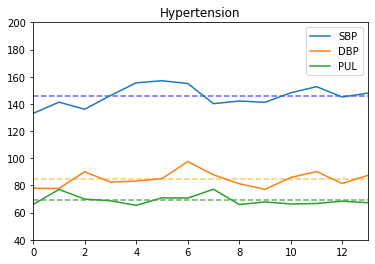

(None, 1)

In [8]:
pd.DataFrame(gen_x[5], columns = ['SBP', 'DBP', 'PUL']).plot(ylim = (40, 200), title = 'Hypertension')
plt.hlines(gen_x[5].mean(axis = 0), 0, 14, colors = ['b', 'orange', 'green'], linestyles="dashed", alpha = 0.6)
plt.show(), gen_y[5]

In [9]:
gen_x[0].mean(axis = 0)

array([145.16933299,  84.89587742,  73.60047964])

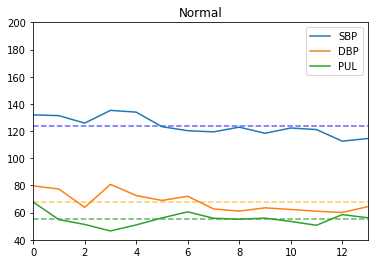

(None, 0)

In [10]:
pd.DataFrame(gen_x[4], columns = ['SBP', 'DBP', 'PUL']).plot(ylim = (40, 200), title = 'Normal')
plt.hlines(gen_x[4].mean(axis = 0), 0, 14, colors = ['b', 'orange', 'green'], linestyles="dashed", alpha = 0.6)
plt.show(), gen_y[4]

## Read real data

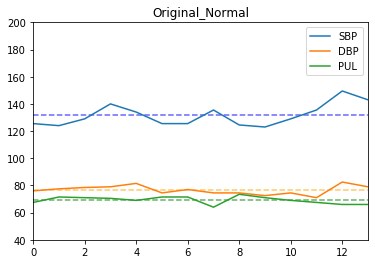

(None, 0)

In [11]:
original = np.load('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data.npz')
pd.DataFrame(original['x'][8], columns = ['SBP', 'DBP', 'PUL']).plot(ylim = (40, 200), title = 'Original_Normal')
plt.hlines(original['x'][8].mean(axis = 0), 0, 14, colors = ['b', 'orange', 'green'], linestyles="dashed", alpha = 0.6)
plt.show(), original['y'][8]

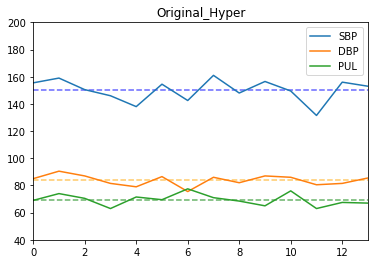

(None, 1)

In [12]:
pd.DataFrame(original['x'][0], columns = ['SBP', 'DBP', 'PUL']).plot(ylim = (40, 200), title = 'Original_Hyper')
plt.hlines(original['x'][0].mean(axis = 0), 0, 14, colors = ['b', 'orange', 'green'], linestyles="dashed", alpha = 0.6)
plt.show(), original['y'][0]

## Dist: Synthesis - Real

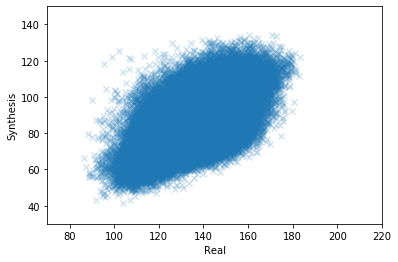

In [310]:
plt.scatter(gen_x[:,:,0].ravel(), gen_x[:,:,1].ravel(), alpha = 0.2, marker = 'x')
plt.xlabel('Real')
plt.ylabel('Synthesis')
plt.xlim(70, 220)
plt.ylim(30,150)
plt.show()

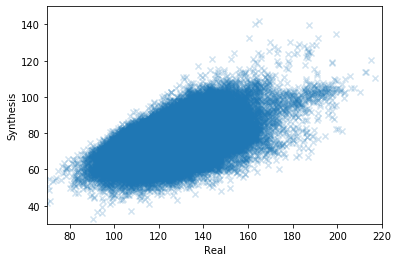

In [311]:
plt.scatter(original['x'][:,:,0].ravel(), original['x'][:,:,1].ravel(), alpha = 0.2, marker = 'x')
plt.xlim(70, 220)
plt.xlabel('Real')
plt.ylabel('Synthesis')
plt.ylim(30,150)
plt.show()

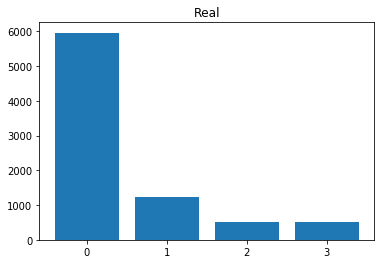

Text(0.5, 1.0, 'Sythesis')

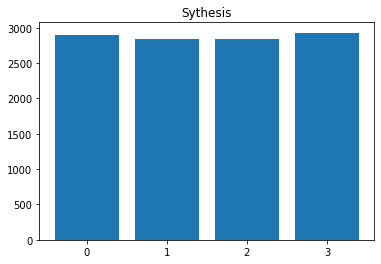

In [312]:
plt.bar(
    np.unique(original['y']).astype('str'), 
    pd.Series(original['y']).value_counts(sort = False).values,
)
plt.title('Real')
plt.show()
plt.bar(
    np.unique(gen_y).astype('str'), 
    pd.Series(gen_y).value_counts(sort = False).values,
)
plt.title('Sythesis')

## Train discremator 

In [314]:
# load synthetic data for training
npz = np.load('/home/hiroshi_koshimizu/work/RCGAN/synthetic_bp.npz')
X_train, y_train = npz['x'], npz['y']
print(X_train.shape)
print(y_train.shape)

# load real data for testing
npz = np.load('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data.npz')
X_eval, y_eval = npz['x'], npz['y']
X_eval, X_valid, y_eval, y_valid = train_test_split(X_eval, y_eval, test_size = 0.3)
print(X_eval.shape)
print(y_eval.shape)
print(X_valid.shape)
print(y_valid.shape)

# hyper parameter for training
input_dim = X_train.shape[2]
sequence = X_train.shape[1]
labels = 4
hidden_dim = 200

# to one-hot vector
y_train = np_utils.to_categorical(y_train, labels)
y_eval = np_utils.to_categorical(y_eval, labels)
y_valid = np_utils.to_categorical(y_valid, labels)

(11506, 14, 3)
(11506,)
(5753, 14, 3)
(5753,)
(2466, 14, 3)
(2466,)


In [315]:
model = Sequential()
model.add(CuDNNLSTM(units=hidden_dim,
               batch_input_shape=(None, sequence, input_dim),
               return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(labels, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="Adam",
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [316]:
fit = model.fit(X_train, y_train,
          batch_size=64,
          epochs=30,
          validation_data=[X_valid, y_valid],
          callbacks=[early_stopping])

Train on 11506 samples, validate on 2466 samples
Epoch 1/30
11506/11506 [==============================] - 2s 154us/step - loss: 0.5173 - acc: 0.7799 - val_loss: 0.5616 - val_acc: 0.7956
Epoch 2/30
11506/11506 [==============================] - 1s 72us/step - loss: 0.1219 - acc: 0.9632 - val_loss: 0.5488 - val_acc: 0.8021
Epoch 3/30
11506/11506 [==============================] - 1s 71us/step - loss: 0.0769 - acc: 0.9778 - val_loss: 0.6263 - val_acc: 0.8333
Epoch 4/30
11506/11506 [==============================] - 1s 72us/step - loss: 0.0780 - acc: 0.9746 - val_loss: 0.6234 - val_acc: 0.8496
Epoch 5/30
11506/11506 [==============================] - 1s 71us/step - loss: 0.0732 - acc: 0.9762 - val_loss: 0.9509 - val_acc: 0.7526
Epoch 6/30
11506/11506 [==============================] - 1s 71us/step - loss: 0.0638 - acc: 0.9791 - val_loss: 0.7329 - val_acc: 0.8423
Epoch 7/30
11506/11506 [==============================] - 1s 71us/step - loss: 0.0614 - acc: 0.9811 - val_loss: 0.9986 - val_acc

              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1790
           1       0.49      0.95      0.65       360
           2       0.32      0.80      0.46       162
           3       0.85      0.42      0.56       154

   micro avg       0.71      0.71      0.71      2466
   macro avg       0.65      0.71      0.61      2466
weighted avg       0.83      0.71      0.73      2466
 samples avg       0.71      0.71      0.71      2466



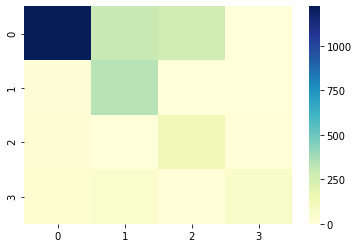

In [317]:
print(classification_report(y_valid, np_utils.to_categorical(model.predict_classes(X_valid))))

sns.heatmap(
    confusion_matrix(y_valid.argmax(axis = 1), np_utils.to_categorical(model.predict_classes(X_valid)).argmax(axis = 1)),
    cmap = 'YlGnBu'
)

In [318]:
model_o = Sequential()
model_o.add(CuDNNLSTM(units=hidden_dim,
               batch_input_shape=(None, sequence, input_dim),
               return_sequences=False))
model_o.add(Dropout(0.5))
model_o.add(Dense(labels, activation='softmax'))
model_o.compile(loss="categorical_crossentropy", optimizer="Adam",
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [319]:
fit = model_o.fit(X_eval, y_eval,
          batch_size=64,
          epochs=30,
          validation_data=[X_valid, y_valid],
          callbacks=[early_stopping])

Train on 5753 samples, validate on 2466 samples
Epoch 1/30
5753/5753 [==============================] - 1s 252us/step - loss: 0.7680 - acc: 0.7182 - val_loss: 0.4753 - val_acc: 0.7968
Epoch 2/30
5753/5753 [==============================] - 0s 79us/step - loss: 0.4041 - acc: 0.8416 - val_loss: 0.3486 - val_acc: 0.8646
Epoch 3/30
5753/5753 [==============================] - 0s 77us/step - loss: 0.2887 - acc: 0.8858 - val_loss: 0.2703 - val_acc: 0.8901
Epoch 4/30
5753/5753 [==============================] - 0s 76us/step - loss: 0.2663 - acc: 0.8929 - val_loss: 0.1675 - val_acc: 0.9298
Epoch 5/30
5753/5753 [==============================] - 0s 77us/step - loss: 0.2248 - acc: 0.9117 - val_loss: 0.1446 - val_acc: 0.9481
Epoch 6/30
5753/5753 [==============================] - 0s 76us/step - loss: 0.2072 - acc: 0.9190 - val_loss: 0.1509 - val_acc: 0.9412
Epoch 7/30
5753/5753 [==============================] - 0s 76us/step - loss: 0.1717 - acc: 0.9366 - val_loss: 0.2431 - val_acc: 0.8938
Epoch 

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1790
           1       0.87      0.86      0.86       360
           2       0.69      0.89      0.77       162
           3       0.69      0.99      0.81       154

   micro avg       0.92      0.92      0.92      2466
   macro avg       0.81      0.92      0.85      2466
weighted avg       0.94      0.92      0.93      2466
 samples avg       0.92      0.92      0.92      2466



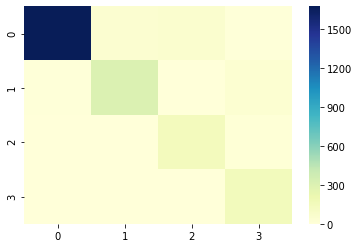

In [320]:
print(classification_report(y_valid, np_utils.to_categorical(model_o.predict_classes(X_valid))))
sns.heatmap(
    confusion_matrix(y_valid.argmax(axis = 1), np_utils.to_categorical(model_o.predict_classes(X_valid)).argmax(axis = 1)),
    cmap = 'YlGnBu'
)

## 個別確認

In [335]:
gan_chk = pd.concat(
    [
        pd.Series(y_valid.argmax(axis = 1), name = 'Real'), 
        pd.Series( 
            np_utils.to_categorical(model.predict_classes(X_valid)).argmax(axis = 1), name = 'Synthesis Trained'
        )
    ],
    axis = 1
)
gan_chk['Match'] = (gan_chk['Real'] == gan_chk['Synthesis Trained'])

In [336]:
gan_chk.groupby(['Match', 'Real']).count()

Synthesis Trained
Match Real                   
False 0                   568
      1                    19
      2                    33
      3                    90
True  0                  1222
      1                   341
      2                   129
      3                    64

In [337]:
gan_chk[
    np.logical_and(gan_chk['Real'] == 3, gan_chk['Match'] == False)
].head(10)

,Real,Synthesis Trained,Match
5,3,0,False
87,3,1,False
127,3,1,False
132,3,0,False
150,3,1,False
202,3,0,False
204,3,1,False
239,3,1,False
256,3,1,False
267,3,0,False


In [338]:
def indivi_key(index_no):
    pd.DataFrame(X_valid[index_no], columns = ['SBP', 'DBP', 'PUL']).plot(ylim = (40, 200), title = index_no)
    plt.hlines(X_valid[index_no].mean(axis = 0), 0, 14, colors = ['b', 'orange', 'green'], linestyles="dashed", alpha = 0.6)
    plt.show(), 
    print(y_valid[index_no], X_valid[index_no].mean(axis = 0))

## しきい値付近

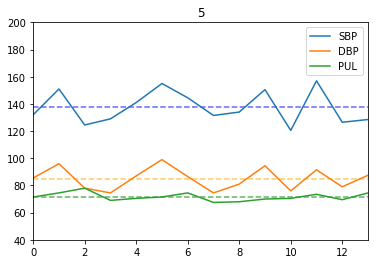

[0. 0. 0. 1.] [137.53571429  85.03571429  71.64285714]


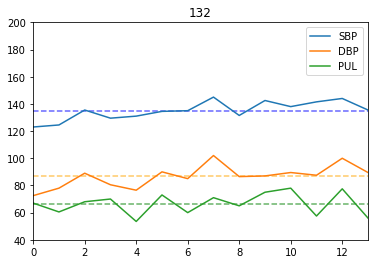

[0. 0. 0. 1.] [135.07142857  86.67857143  66.57142857]


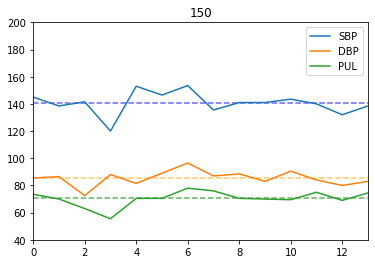

[0. 0. 0. 1.] [140.67857143  85.39285714  70.39285714]


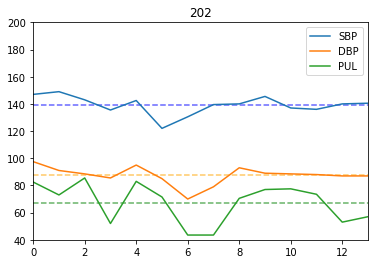

[0. 0. 0. 1.] [139.14285714  87.42857143  67.35714286]


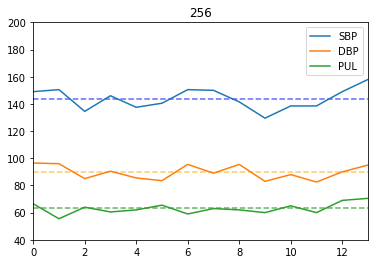

[0. 0. 0. 1.] [143.82142857  89.67857143  63.03571429]


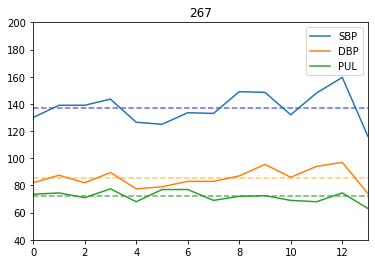

[0. 0. 0. 1.] [137.32142857  85.5         71.89285714]


In [354]:
indivi_key(5)
indivi_key(132)
indivi_key(150)
indivi_key(202)
indivi_key(256)
indivi_key(267)

## SBPが高い

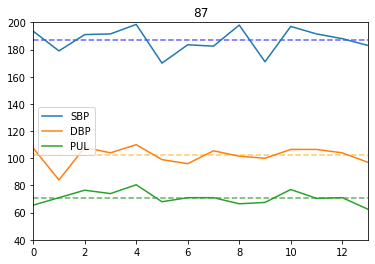

[0. 0. 0. 1.] [187.         102.10714286  70.89285714]


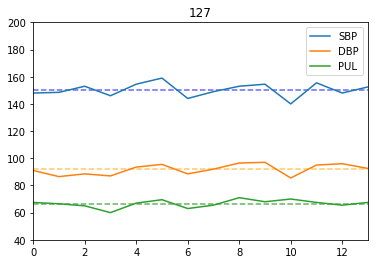

[0. 0. 0. 1.] [150.39285714  91.78571429  66.67857143]


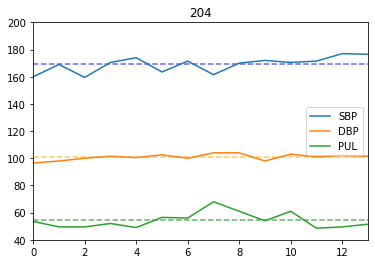

[0. 0. 0. 1.] [169.07142857 100.89285714  54.25      ]


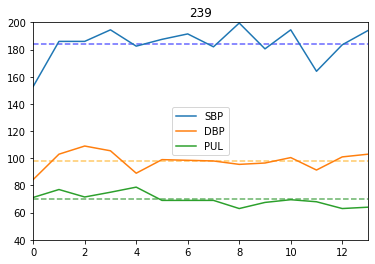

[0. 0. 0. 1.] [184.20238095  98.1547619   69.67261905]


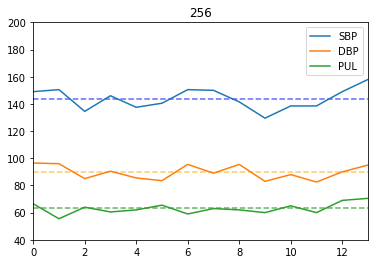

[0. 0. 0. 1.] [143.82142857  89.67857143  63.03571429]


In [352]:
indivi_key(87)
indivi_key(127)
indivi_key(204)
indivi_key(239)

極端な例と境界領域が判定ミスしやすい ⇒ 境界付近のデータがConditionをうまく付与できてない？

In [369]:
for i in zip(gen_x[:30], gen_y[:30]):
    print(i[0].mean(axis = 0), i[1])

[149.51805856  79.71724558  54.41039525] 1
[143.14969952  98.311305    67.71517967] 3
[125.25695034  85.96828521  68.71967046] 2
[131.35057516  92.16485519  67.08458858] 2
[147.80830204  78.26205699  54.59320623] 1
[124.73942269  72.93171757  55.60618126] 0
[152.88340771 100.82996398  59.70692061] 3
[129.98400888  91.79966252  69.45701935] 2
[130.50756853  82.23051368  64.63820889] 0
[115.59964201  86.66483072  86.80410606] 2
[142.86288018 100.05206505  82.06990886] 3
[143.2524613   98.11581045  78.07354674] 3
[147.84184598  99.7676275   66.26425062] 3
[122.95564378  77.81880945  69.35294482] 0
[142.17782895  98.0905843   76.39638036] 3
[151.88090211 101.80388507  63.46815885] 3
[147.39111654  86.50295915  62.88581554] 1
[131.86348204  93.60601476  70.43386447] 2
[137.48997016  74.71744805  70.47966789] 1
[129.38650744  89.65571964  67.09266497] 2
[122.03201434  80.33741203  80.24923797] 0
[144.80378086  99.65626646  76.07090505] 3
[146.6618604   86.112716    64.82749537] 1
[142.333283

([array([2049.,  900.,  737.,  631.,  648.,  606.,  706.,  795.,  956.,
         1972.]),
  array([4279., 1069.,  761.,  657.,  513.,  502.,  436.,  490.,  550.,
          743.]),
  array([5948.,  872.,  639.,  474.,  388.,  384.,  302.,  315.,  313.,
          365.])],
 array([4.74709009e-30, 9.99999989e-02, 1.99999998e-01, 2.99999997e-01,
        3.99999996e-01, 4.99999995e-01, 5.99999993e-01, 6.99999992e-01,
        7.99999991e-01, 8.99999990e-01, 9.99999989e-01]),
 <a list of 3 Lists of Patches objects>)

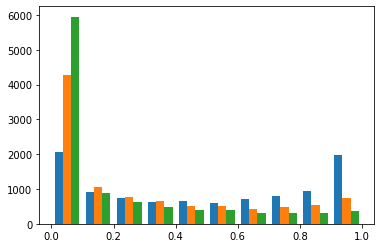

In [421]:
plt.hist(np.random.dirichlet([0.5, 0.3, 0.2], size = 10000))